In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

root_dir = '/content/gdrive/MyDrive/Data'

Mounted at /content/gdrive


In [3]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from pandas.core.frame import DataFrame
from time import sleep
import math

Extracting labels

Getting participants section in the merged file

In [ ]:
data_loading_dir = os.path.join(root_dir, "18 participants/AX3/DownsampledDataset")
participants = 18
experience = 1
sections = [0]
count = 0

for participant in range(1, participants + 1):
  file_name = os.path.join(data_loading_dir, "Dataset_participant" + str(participant) + ".pkl")
  new_dataset = pd.read_pickle(file_name)
  count = count + new_dataset.shape[0]
  sections.append(count)

data_loading_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))
save_file = os.path.join(data_loading_dir, "Sections.pkl")

sections_df = DataFrame({'Sections': sections})
sections_df.to_pickle(save_file)
#print(sections_df)

Extracting labelled and unlabelled dataset

In [ ]:
participants = 18
experience = 1

psg_dir = os.path.join(root_dir, "18 participants/PSG")
features_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))

# PSG Files
PSG_Consensus_Sleep_profile = "SDRI001_PSG_Consensus Sleep profile_0"
PSG_Heart_Rate = "SDRI001_PSG_Heart Rate_0"
PSG_HRV_HF = "SDRI001_PSG_HRV HF_0"
PSG_HRV_LF = "SDRI001_PSG_HRV LF_0"
PSG_Position = "SDRI001_PSG_Position_0"
PSG_RR_Interval = "SDRI001_PSG_RR-Interval_0"
PSG_SpO2 = "SDRI001_PSG_SpO2_0"

def get_PSG_dataset(PSF_DIR, PSG_File, participant):
  file_name = os.path.join(PSF_DIR, PSG_File + str(participant).zfill(2) + "V4_N1.txt")
  dataset = pd.read_csv(file_name, sep=" ")
  return dataset

def reformatPSGDatetime(date, time):
  #File 9 Anamoly
  if not isinstance(date, str):
    after_midnight = 0
    if int(time[:2]) < 22:
      after_midnight = 1
    date = str(26+after_midnight) + ".02.2020"

  date = date.split('.')
  time = time.split(',')[0]
  datetime = date[2] + '-' + date[1] + '-' + date[0] + ' ' + time
  return datetime

def extractSleepProfileLabels(dataset, starting_rows=5):
  columns = np.array(dataset.columns)
  columns[0] = 'Date'
  columns[1] = 'Time'
  columns[2] = 'Sleep State'
  dataset.columns = columns
  dataset = dataset.iloc[starting_rows:]
  dataset['Label'] = dataset.apply(lambda x: reformatPSGDatetime(x['Date'], x['Time']), axis=1)
  dataset = dataset[['Label', 'Sleep State']]
  return dataset

def extractNonSleepProfileLabels(dataset, starting_rows=5):
  columns = np.array(dataset.columns)
  columns[0] = 'Date'
  columns[1] = 'Time'
  columns[2] = 'Value'
  columns[3] = 'Sleep State'
  #File 9 Anamoly
  if ',' in dataset.iloc[starting_rows][0]:
    columns[0] = 'Time'
    columns[1] = 'Value'
    columns[2] = 'Sleep State'
    columns[3] = 'Date'
    dataset.columns = columns
    print(dataset.iloc[starting_rows]['Date'])

  dataset.columns = columns
  dataset = dataset.iloc[starting_rows:]
  dataset['Label'] = dataset.apply(lambda x: reformatPSGDatetime(x['Date'], x['Time']), axis=1)
  dataset = dataset[['Label', 'Value', 'Sleep State']]
  return dataset

def get_Features_dataset(features_dir, file="Features.pkl"):
  file_name = os.path.join(features_dir, file)
  dataset = pd.read_pickle(file_name)
  return dataset

def getSection(features_dir):
  file_name = os.path.join(features_dir, "Sections.pkl")
  dataset = pd.read_pickle(file_name)
  dataset = np.array(dataset)
  return dataset.reshape(dataset.shape[0])

def get_Feature_Dataset(sections, features_dataset, participant):
  from_idx = sections[participant-1]
  to_idx = sections[participant]
  return features_dataset.iloc[from_idx:to_idx]

def extract_unlabelled_dataset(feature_dataset, psg_dataset):
  feature_dataset = pd.merge(feature_dataset, psg_dataset, how='left', on="Label")
  return feature_dataset[feature_dataset['Sleep State'].isnull()]

def SaveDataset(dataset, file_name):
  save_file = os.path.join(features_dir, file_name)
  dataset.to_pickle(save_file)

features_dataset = get_Features_dataset(features_dir)
raw_dataset = get_Features_dataset(features_dir, "Raw.pkl")
sections = getSection(features_dir)

Extracting labels of Heart rate and Positions dataset


In [ ]:
#for i in range(1, 2):
  #psg_dataset = get_PSG_dataset(psg_dir, PSG_Heart_Rate, i)
  #psg_dataset = psg_dataset.reset_index()
  #psg_dataset = extractNonSleepProfileLabels(psg_dataset)

  #psg_dataset = get_PSG_dataset(psg_dir, PSG_Position, i)
  #psg_dataset = extractNonSleepProfileLabels(psg_dataset, 6)
  #print(psg_dataset.shape)
  #print(psg_dataset.head(7))

psg_dataset = get_PSG_dataset(psg_dir, PSG_Position, 1)
psg_dataset = psg_dataset.reset_index()
psg_dataset = extractNonSleepProfileLabels(psg_dataset, 6)
feature_dataset = get_Feature_Dataset(sections, features_dataset, 1)

labelled_dataset = pd.merge(feature_dataset, psg_dataset, on="Label")
unlabelled_dataset = extract_unlabelled_dataset(feature_dataset, psg_dataset)

for participant in range(2, participants + 1):
  psg_dataset = get_PSG_dataset(psg_dir, PSG_Position, participant)
  psg_dataset = psg_dataset.reset_index()
  print(psg_dataset.shape)

  psg_dataset = extractNonSleepProfileLabels(psg_dataset, 6)
  feature_dataset = get_Feature_Dataset(sections, features_dataset, participant)

  new_labelled_dataset = pd.merge(feature_dataset, psg_dataset, on="Label")
  new_unlabelled_dataset = extract_unlabelled_dataset(feature_dataset, psg_dataset)

  labelled_dataset = labelled_dataset.append(new_labelled_dataset, ignore_index=True)
  unlabelled_dataset = unlabelled_dataset.append(new_unlabelled_dataset, ignore_index=True)

SaveDataset(labelled_dataset, "LabelledPOS")
SaveDataset(unlabelled_dataset, "UnlabelledPOS")

print(feature_dataset.shape)
print(labelled_dataset.shape)
print(unlabelled_dataset.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(1205, 4)
(1204, 4)
(1203, 4)
(1206, 4)
nan
(1206, 4)
(1208, 4)
(1207, 4)
(1211, 4)
nan
(1206, 4)
(1208, 4)
(1213, 4)
(1204, 4)
(1207, 4)
(1204, 4)
(1198, 4)
(1206, 4)
(1207, 4)
(16763, 25)
(17993, 27)
(497387, 27)


Extracting labels of Sleep profile dataset

In [ ]:
psg_dataset = get_PSG_dataset(psg_dir, PSG_Consensus_Sleep_profile, 1)
psg_dataset = extractSleepProfileLabels(psg_dataset)
feature_dataset = get_Feature_Dataset(sections, features_dataset, 1)

labelled_dataset = pd.merge(feature_dataset, psg_dataset, on="Label")
unlabelled_dataset = extract_unlabelled_dataset(feature_dataset, psg_dataset)

for participant in range(2, participants + 1):
  psg_dataset = get_PSG_dataset(psg_dir, PSG_Consensus_Sleep_profile, participant)
  psg_dataset = extractSleepProfileLabels(psg_dataset)
  feature_dataset = get_Feature_Dataset(sections, features_dataset, participant)

  new_labelled_dataset = pd.merge(feature_dataset, psg_dataset, on="Label")
  new_unlabelled_dataset = extract_unlabelled_dataset(feature_dataset, psg_dataset)

  labelled_dataset = labelled_dataset.append(new_labelled_dataset, ignore_index=True)
  unlabelled_dataset = unlabelled_dataset.append(new_unlabelled_dataset, ignore_index=True)

SaveDataset(labelled_dataset, "Labelled")
SaveDataset(unlabelled_dataset, "Unlabelled")

print(psg_dataset.shape)
print(feature_dataset.shape)
print(labelled_dataset.shape)
print(unlabelled_dataset.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(1202, 2)
(16763, 25)
(19209, 26)
(496171, 26)


PseudoLabeling module

In [ ]:
experience = 1

features_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))
file_name = os.path.join(features_dir, "Labelled")

def encode_sleep_stage(val):
  arr = {'N1':0, 'N2':1, 'N3':2, 'REM':3, 'Wake':4, 'Artefact':np.NaN, 'A':np.NaN}
  return arr[val]

def encode_sleep_state(val):
  arr = {'N1':0, 'N2':1, 'N3':2, 'REM':3, 'Wake':4, 'Artefact':np.NaN, 'A':np.NaN}
  return arr[val]

dataset = pd.read_pickle(file_name)
dataset['Sleep State'] = dataset['Sleep State'].apply(lambda x: encode_sleep_stage(x))
dataset['Sleep State'] = pd.Series(np.array(dataset['Sleep State'])).interpolate()
dataset['Sleep State'] = np.array(dataset['Sleep State'].replace(to_replace = np.nan, value=4), dtype=np.int64)


Comparisons with Non-feature extracted (Semi-supervised) Pseudo labeling

In [ ]:
experience = 1

features_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))
file_name = os.path.join(features_dir, "Raw")


CNN Module

1    6536
4    5670
2    2740
0    2140
3    2123
Name: Sleep State, dtype: int64
(19209, 24, 1, 1)
(19209, 5)
Epoch 1/50
17288/17288 [==============================] - 33s 2ms/step - loss: 1.5160 - accuracy: 0.3329 - val_loss: 1.5063 - val_accuracy: 0.3316
Epoch 2/50
17288/17288 [==============================] - 32s 2ms/step - loss: 1.4752 - accuracy: 0.3808 - val_loss: 1.4348 - val_accuracy: 0.4336
Epoch 3/50
17288/17288 [==============================] - 31s 2ms/step - loss: 1.4399 - accuracy: 0.4272 - val_loss: 1.4692 - val_accuracy: 0.4331
Epoch 4/50
17288/17288 [==============================] - 32s 2ms/step - loss: 1.4417 - accuracy: 0.4281 - val_loss: 1.4501 - val_accuracy: 0.4326
Epoch 5/50
17288/17288 [==============================] - 32s 2ms/step - loss: 1.4545 - accuracy: 0.4292 - val_loss: 1.4509 - val_accuracy: 0.4154
Epoch 6/50
17288/17288 [==============================] - 32s 2ms/step - loss: 1.4629 - accuracy: 0.4265 - val_loss: 1.4536 - val_accuracy: 0.4331
Epoch 7

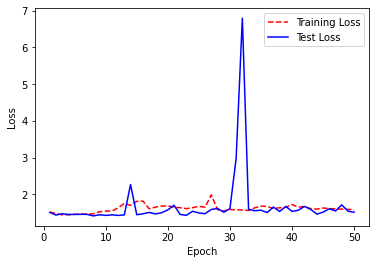

<Figure size 504x504 with 0 Axes>

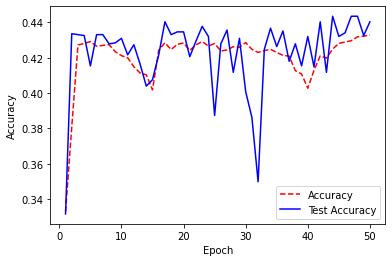

<Figure size 504x504 with 0 Axes>

[[  0 121   1   0  33]
 [  0 613   0   0  94]
 [  0 189   0   0  10]
 [  0 292   0   0  29]
 [  0 306   0   0 233]]
Precision for N1 is 0.0
Precision for N2 is 0.87
Precision for N3 is 0.0
Precision for REM is 0.0
Precision for Wake is 0.43
Accuracy is 0.44


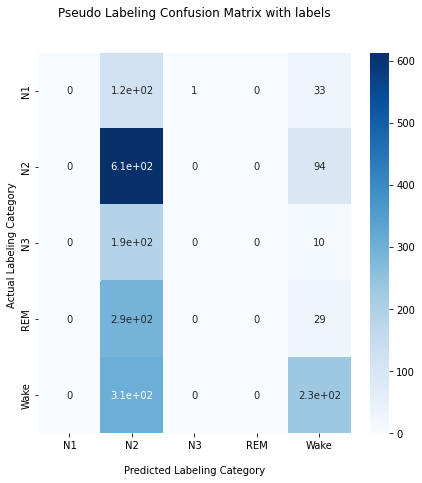

([0.0, 0.87, 0.0, 0.0, 0.43], 0.44)

In [ ]:
n = dataset.shape[0]
train_ratio = 0.9
separate_id = int(n * train_ratio)

labels = np.zeros((n,5))

for i in range(n):
  label = dataset.iloc[i]['Sleep State']
  labels[i][label] = 1

print(dataset['Sleep State'].value_counts())
dataset = dataset.drop(['Label', 'Sleep State'], axis=1)
dataset += 0.001
dataset = np.array(dataset)

dataset = dataset.reshape((dataset.shape[0], dataset.shape[1], 1, 1))

x_train = dataset[:separate_id]
y_train = labels[:separate_id]

x_test = dataset[separate_id:]
y_test = labels[separate_id:]

print(dataset.shape)
#print(dataset[0])
print(labels.shape)

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
#create model
model = Sequential()
#add model layers
model.add(Conv2D(24, kernel_size=(1,1), activation='relu', input_shape=(dataset.shape[1],1,1)))
#model.add(MaxPooling2D((1,1)))
model.add(Conv2D(16, kernel_size=(1,1), activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(5, activation='softmax'))

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
sgd = SGD(learning_rate=0.01)
rms = RMSprop(learning_rate=0.001)
adam = Adam(learning_rate=0.003, epsilon=0.01)
model.compile(optimizer=rms,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=1 ,validation_data=(x_test, y_test), epochs=50)

def plot_graph(x, y, z, x_label, y_label, legends, figsize=(7,7)):
  plt.plot(z, x, 'r--')
  plt.plot(z, y, 'b-')
  plt.legend(legends)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.figure(figsize=figsize)
  plt.show();

history = model.history

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Get training and test loss histories
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

plot_graph(training_loss, test_loss, epoch_count, 'Epoch', 'Loss', ['Training Loss', 'Test Loss'])
plot_graph(accuracy, val_accuracy, epoch_count, 'Epoch', 'Accuracy', ['Accuracy', 'Test Accuracy'])

test_labels = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)
Labels = ['N1','N2', 'N3', 'REM', 'Wake']

printConfusionMatrix(test_labels, y_pred, Labels, show=True)


SVM Module train/test dataset

In [ ]:
labels = np.array(dataset['Sleep State'])
new_dataset = np.array(dataset.drop(['Label', 'Sleep State'], axis=1))

n = dataset.shape[0]
train_ratio = 0.9

def get_n_rand_nums(start, end, totalNums):
  randIdx = random.sample(range(start, end), totalNums)
  randIdx.sort()
  return randIdx

randIdx = random.sample(range(0, n), int(n*(1-train_ratio)))
randIdx.sort()

# divides up the array to two arrays using the ids array
def separateArr(arr, ids):
  ids_id = 0
  part_1 = []
  part_2 = []

  print(arr.shape)

  for i in range(arr.shape[0]):
    row = arr[i]
    if ids_id < len(ids) and i == ids[ids_id]:
      part_2.append(row)
      ids_id += 1
    else:
      part_1.append(row)

  return np.array(part_1), np.array(part_2)

print(randIdx)

# spliting the original dataset to train/test splits
train_set, test_set = separateArr(new_dataset, randIdx)
train_labels, test_labels = separateArr(labels, randIdx)

print(train_set.shape)
print(test_set.shape)

print(train_labels.shape)
print(test_labels.shape)

[3, 6, 16, 20, 29, 36, 42, 45, 47, 55, 58, 68, 80, 105, 109, 115, 122, 129, 130, 135, 147, 153, 178, 180, 208, 233, 240, 273, 281, 286, 289, 290, 292, 294, 318, 328, 331, 336, 344, 346, 347, 354, 364, 365, 371, 375, 383, 419, 429, 431, 446, 453, 467, 479, 482, 502, 524, 530, 539, 554, 555, 559, 562, 565, 577, 589, 603, 611, 612, 620, 631, 639, 640, 649, 666, 673, 688, 694, 697, 705, 711, 722, 729, 746, 771, 779, 786, 793, 803, 808, 813, 871, 872, 873, 875, 879, 899, 905, 940, 946, 950, 956, 960, 969, 999, 1014, 1031, 1048, 1052, 1053, 1062, 1063, 1086, 1138, 1161, 1162, 1163, 1166, 1171, 1172, 1174, 1185, 1193, 1213, 1217, 1220, 1222, 1225, 1245, 1250, 1251, 1258, 1265, 1283, 1293, 1297, 1304, 1316, 1326, 1343, 1345, 1353, 1359, 1373, 1398, 1399, 1431, 1433, 1450, 1452, 1456, 1467, 1470, 1480, 1486, 1492, 1496, 1518, 1519, 1521, 1522, 1526, 1532, 1534, 1541, 1547, 1573, 1575, 1580, 1581, 1587, 1590, 1622, 1636, 1639, 1683, 1691, 1693, 1699, 1709, 1716, 1718, 1721, 1723, 1727, 1733, 176

Result methods

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns

def convertMultiLabelToSingleLabel(result):
  res = 1
  if result < 4:
    res = 0
  return res

def printConfusionMatrix(test_labels, y_pred, Labels, show=True):
  cf_matrix = confusion_matrix(test_labels, y_pred)
  #cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

  print(cf_matrix)

  precisions = []

  total_vals = 0
  tps = 0
  for i in range(cf_matrix.shape[0]):
    sum_vals = cf_matrix[i].sum()
    total_vals += sum_vals
    tps += cf_matrix[i][i]
    precision = round(cf_matrix[i][i]/sum_vals, 2)
    precisions.append(precision)
    if show:
      print("Precision for " + Labels[i] + " is " + str(precision))

  accuracy = round(tps/total_vals, 2)
  if show:
    print("Accuracy is " + str(accuracy))
    #plot_confusion_matrix(conf_mat=cf_matrix, show_normed=True, figsize=(7,7))

    fig, siz = plt.subplots(figsize=(7,7))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', ax=siz)

    ax.set_title('Pseudo Labeling Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Labeling Category')
    ax.set_ylabel('Actual Labeling Category ');

    ## Ticket labels - List must be in alphabetical order

    ax.xaxis.set_ticklabels(Labels)
    ax.yaxis.set_ticklabels(Labels)

    ## Display the visualization of the Confusion Matrix.
    plt.show()

  return precisions, accuracy

Running SVM module

Gamma: 0.01
[[  2 153   4   2  48]
 [  9 468  18   7 153]
 [  4 205   5   9  56]
 [  0 146   5   1  45]
 [  4 404  19   4 149]]
[[1038  302]
 [ 431  149]]
Precision for Sleep is 0.77
Precision for Wake is 0.26
Accuracy is 0.62


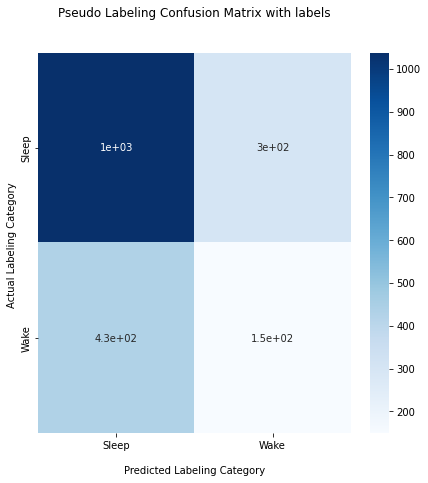

Gamma: 0.03
[[  2 171   2   2  32]
 [  5 526   7   6 111]
 [  4 227   5   3  40]
 [  0 157   0   2  38]
 [  4 454  12   2 108]]
[[1119  221]
 [ 472  108]]
Precision for Sleep is 0.84
Precision for Wake is 0.19
Accuracy is 0.64


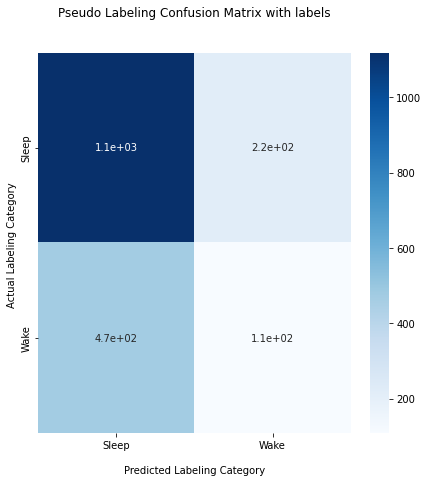

Gamma: 0.05
[[  3 177   1   1  27]
 [  3 565   8   2  77]
 [  5 239   3   1  31]
 [  0 164   0   1  32]
 [  3 486  10   1  80]]
[[1173  167]
 [ 500   80]]
Precision for Sleep is 0.88
Precision for Wake is 0.14
Accuracy is 0.65


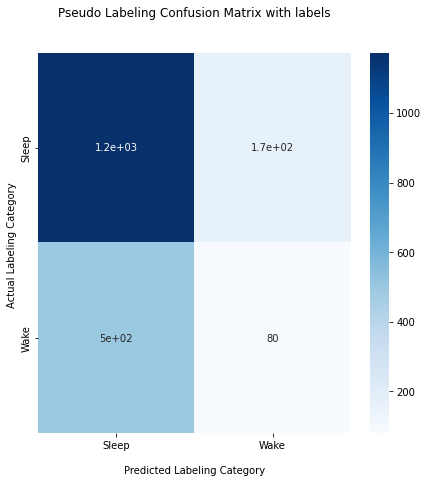

Gamma: 0.07
[[  3 180   1   1  24]
 [  4 577   6   1  67]
 [  4 244   2   1  28]
 [  0 168   1   1  27]
 [  2 501   8   1  68]]
[[1194  146]
 [ 512   68]]
Precision for Sleep is 0.89
Precision for Wake is 0.12
Accuracy is 0.66


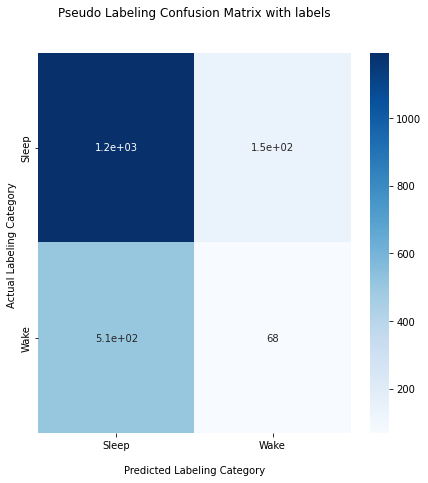

Gamma: 0.09
[[  3 183   1   1  21]
 [  5 584   7   3  56]
 [  3 249   1   1  25]
 [  0 172   2   1  22]
 [  2 506   7   1  64]]
[[1216  124]
 [ 516   64]]
Precision for Sleep is 0.91
Precision for Wake is 0.11
Accuracy is 0.67


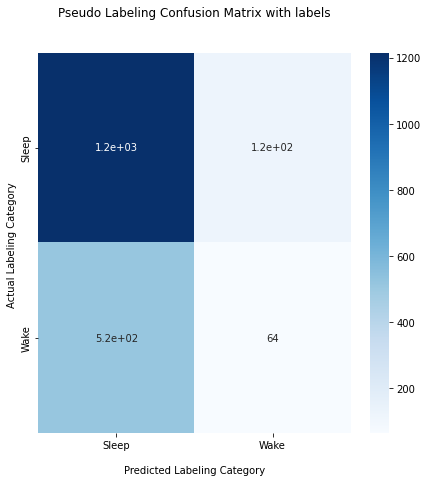

Gamma: 0.11
[[  3 186   1   0  19]
 [  3 586  11   4  51]
 [  1 251   1   2  24]
 [  0 173   2   0  22]
 [  2 513   7   1  57]]
[[1224  116]
 [ 523   57]]
Precision for Sleep is 0.91
Precision for Wake is 0.1
Accuracy is 0.67


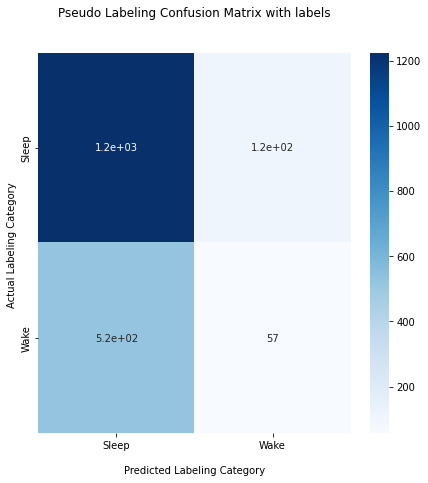

Gamma: 0.13
[[  2 186   1   0  20]
 [  4 593  10   4  44]
 [  1 254   1   2  21]
 [  0 176   2   0  19]
 [  2 519   5   1  53]]
[[1236  104]
 [ 527   53]]
Precision for Sleep is 0.92
Precision for Wake is 0.09
Accuracy is 0.67


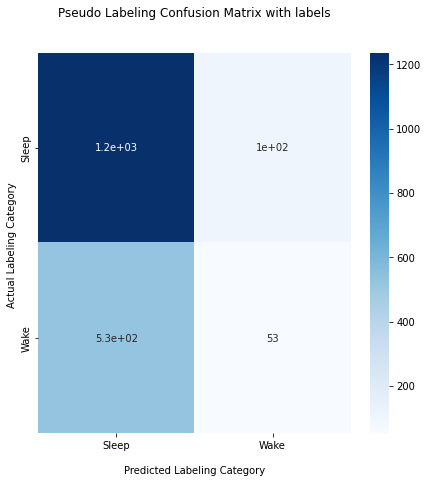

Gamma: 0.15
[[  1 186   2   0  20]
 [  3 599   9   3  41]
 [  1 254   1   2  21]
 [  0 176   2   0  19]
 [  2 525   4   1  48]]
[[1239  101]
 [ 532   48]]
Precision for Sleep is 0.92
Precision for Wake is 0.08
Accuracy is 0.67


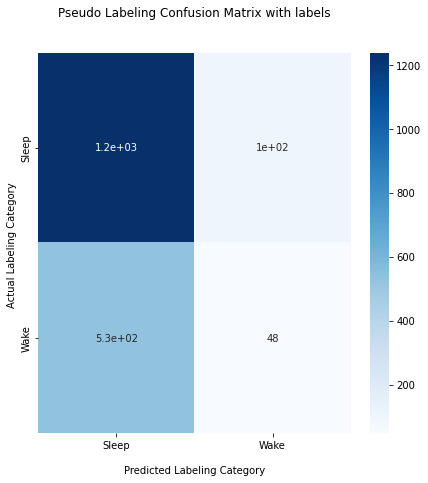

Gamma: 0.17
[[  1 192   1   0  15]
 [  3 607   8   1  36]
 [  1 255   1   2  20]
 [  0 178   2   1  16]
 [  2 527   4   0  47]]
[[1253   87]
 [ 533   47]]
Precision for Sleep is 0.94
Precision for Wake is 0.08
Accuracy is 0.68


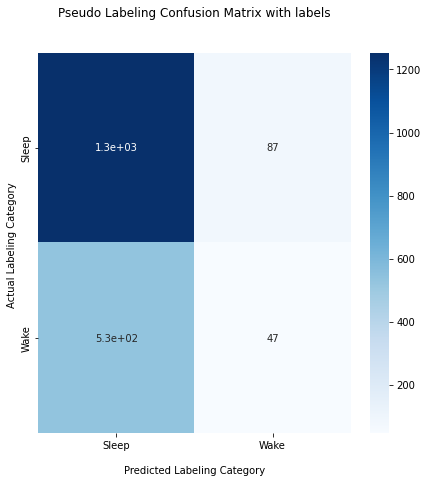

Gamma: 0.19
[[  1 193   1   0  14]
 [  3 610   8   1  33]
 [  1 257   0   2  19]
 [  0 178   2   1  16]
 [  2 533   3   0  42]]
[[1258   82]
 [ 538   42]]
Precision for Sleep is 0.94
Precision for Wake is 0.07
Accuracy is 0.68


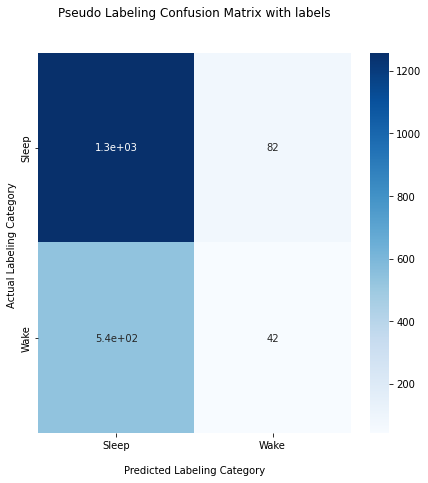

Gamma: 0.21
[[  1 192   1   0  15]
 [  2 612   7   0  34]
 [  1 258   0   2  18]
 [  0 181   2   1  13]
 [  2 535   3   0  40]]
[[1260   80]
 [ 540   40]]
Precision for Sleep is 0.94
Precision for Wake is 0.07
Accuracy is 0.68


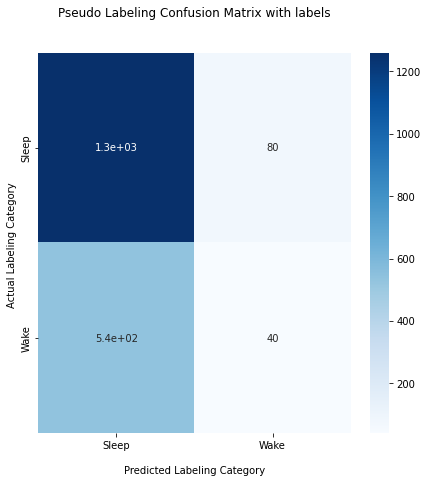

Gamma: 0.23
[[  1 193   1   0  14]
 [  2 613   7   0  33]
 [  1 259   0   2  17]
 [  0 182   2   1  12]
 [  2 537   3   0  38]]
[[1264   76]
 [ 542   38]]
Precision for Sleep is 0.94
Precision for Wake is 0.07
Accuracy is 0.68


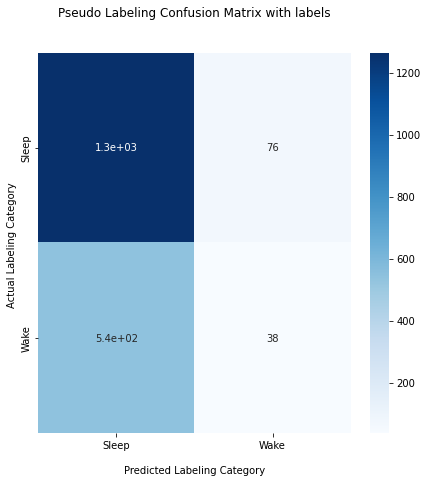

Gamma: 0.25
[[  1 194   1   0  13]
 [  1 616   6   0  32]
 [  1 262   0   2  14]
 [  0 183   2   1  11]
 [  1 539   3   0  37]]
[[1270   70]
 [ 543   37]]
Precision for Sleep is 0.95
Precision for Wake is 0.06
Accuracy is 0.68


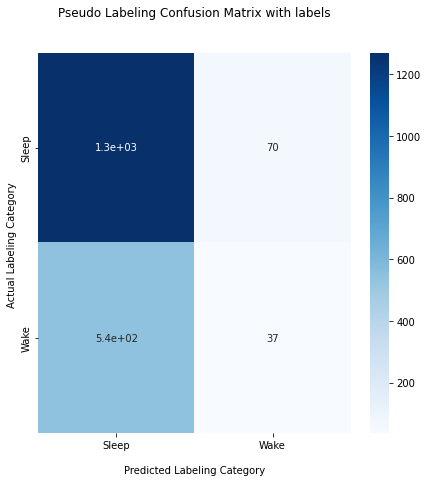

Gamma: 0.27
[[  1 195   1   0  12]
 [  1 616   6   0  32]
 [  1 263   0   2  13]
 [  1 183   2   1  10]
 [  1 541   3   0  35]]
[[1273   67]
 [ 545   35]]
Precision for Sleep is 0.95
Precision for Wake is 0.06
Accuracy is 0.68


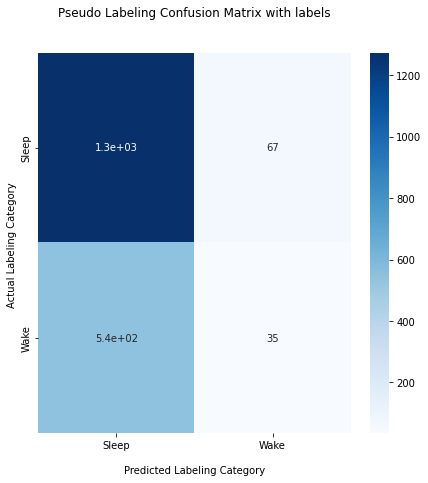

Gamma: 0.29
[[  1 195   1   0  12]
 [  1 616   6   0  32]
 [  1 263   0   2  13]
 [  1 185   2   1   8]
 [  1 541   3   0  35]]
[[1275   65]
 [ 545   35]]
Precision for Sleep is 0.95
Precision for Wake is 0.06
Accuracy is 0.68


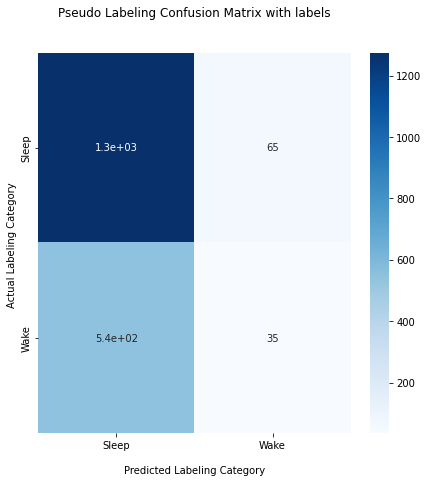

Gamma: 0.31
[[  1 195   1   0  12]
 [  1 618   6   0  30]
 [  1 262   0   2  14]
 [  1 185   2   1   8]
 [  1 544   1   0  34]]
[[1276   64]
 [ 546   34]]
Precision for Sleep is 0.95
Precision for Wake is 0.06
Accuracy is 0.68


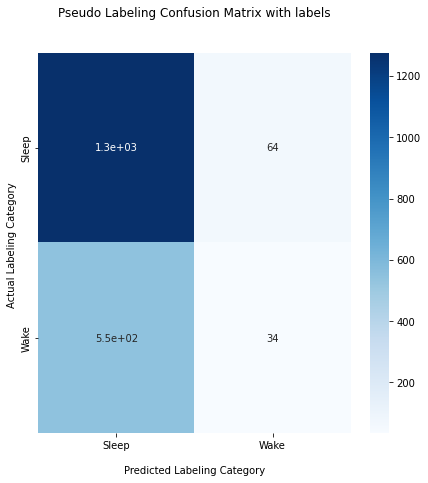

Gamma: 0.33
[[  0 196   1   0  12]
 [  1 622   5   0  27]
 [  0 263   0   2  14]
 [  1 185   2   1   8]
 [  1 546   1   0  32]]
[[1279   61]
 [ 548   32]]
Precision for Sleep is 0.95
Precision for Wake is 0.06
Accuracy is 0.68


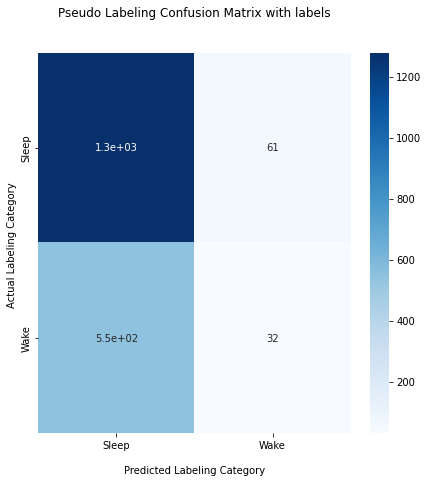

Gamma: 0.35
[[  0 196   1   0  12]
 [  1 620   5   1  28]
 [  0 263   0   2  14]
 [  1 186   2   1   7]
 [  1 547   1   0  31]]
[[1279   61]
 [ 549   31]]
Precision for Sleep is 0.95
Precision for Wake is 0.05
Accuracy is 0.68


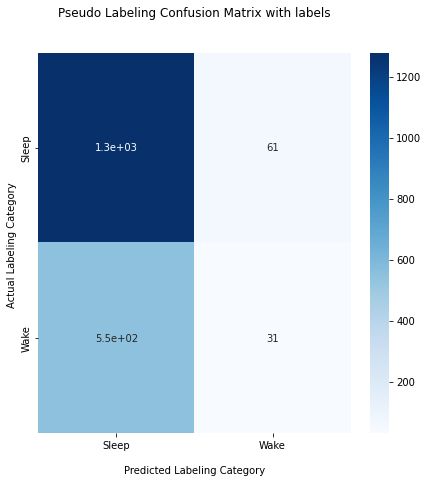

In [ ]:
from sklearn import svm
test_labels_single = list(map(convertMultiLabelToSingleLabel, test_labels))
#print(test_labels.value_counts())

clf = svm.SVC(gamma=0.1)
clf.fit(train_set, train_labels)

y_pred = clf.predict(test_set)

Labels = ['N1','N2', 'N3', 'REM', 'Wake']

printConfusionMatrix(test_labels, y_pred, Labels, False)

Labels = ['Sleep', 'Wake']
y_pred_single = list(map(convertMultiLabelToSingleLabel, y_pred))

printConfusionMatrix(test_labels_single, y_pred_single, Labels)  

Finding the optimal gamma value for SVM

In [ ]:
from sklearn import svm
test_labels_single = list(map(convertMultiLabelToSingleLabel, test_labels))
train_labels_single = list(map(convertMultiLabelToSingleLabel, train_labels))

gammas = []
precisions_individual_test = []
accuracies_individual_test = []

precisions_SW_test = []
accuracies_SW_test = []

precisions_individual_train = []
accuracies_individual_train = []

precisions_SW_train = []
accuracies_SW_train = []

for gamma in range(5, 1005, 5):
  gammas.append(gamma/10000)

  clf = svm.SVC(kernel='rbf', C=10, gamma=(gamma/10000))
  clf.fit(train_set, train_labels)

  print("Gamma: " + str(gamma/10000))

  y_pred = clf.predict(test_set)

  Labels = ['N1','N2', 'N3', 'REM', 'Wake']
  precision_individual_test, accuracy_individual_test = printConfusionMatrix(test_labels, y_pred, Labels, False)
  precisions_individual_test.append(precision_individual_test)
  accuracies_individual_test.append(accuracy_individual_test)

  Labels = ['Sleep', 'Wake']
  y_pred_single = list(map(convertMultiLabelToSingleLabel, y_pred))

  precision_SW_test, accuracy_SW_test = printConfusionMatrix(test_labels_single, y_pred_single, Labels, False)
  precisions_SW_test.append(precision_SW_test)
  accuracies_SW_test.append(accuracy_SW_test)

  y_pred = clf.predict(train_set)

  Labels = ['N1','N2', 'N3', 'REM', 'Wake']
  precision_individual_train, accuracy_individual_train = printConfusionMatrix(train_labels, y_pred, Labels, False)
  precisions_individual_train.append(precision_individual_train)
  accuracies_individual_train.append(accuracy_individual_train)

  Labels = ['Sleep', 'Wake']
  y_pred_single = list(map(convertMultiLabelToSingleLabel, y_pred))

  precision_SW_train, accuracy_SW_train = printConfusionMatrix(train_labels_single, y_pred_single, Labels, False)
  precisions_SW_train.append(precision_SW_train)
  accuracies_SW_train.append(accuracy_SW_train)


Gamma: 0.0005
[[  3 145   9   7  62]
 [ 29 406  35  29 128]
 [ 13 180  15   9  60]
 [  9 130  12   9  49]
 [ 36 304  31  27 183]]
[[1040  299]
 [ 398  183]]
[[ 679  862   46   19  308]
 [  46 5170   64   27  602]
 [  35 1230  861   28  309]
 [  35  858   45  706  270]
 [  62 1506   72   28 3421]]
[[10711  1489]
 [ 1668  3421]]
Gamma: 0.001
[[  7 136  15   8  60]
 [ 41 379  37  31 139]
 [ 15 179  12  17  54]
 [  8 125  15  10  51]
 [ 42 293  33  28 185]]
[[1035  304]
 [ 396  185]]
[[ 896  693   52   22  251]
 [  54 5264   69   26  496]
 [  31  986 1162   29  255]
 [  40  679   47  917  231]
 [  48 1190   73   23 3755]]
[[10967  1233]
 [ 1334  3755]]
Gamma: 0.0015
[[  4 132  18   8  64]
 [ 35 360  46  41 145]
 [ 19 167  15  15  61]
 [  9 120  14  14  52]
 [ 37 290  38  32 184]]
[[1017  322]
 [ 397  184]]
[[1038  579   46   18  233]
 [  46 5339   77   21  426]
 [  28  828 1350   28  229]
 [  30  586   41 1049  208]
 [  45  968   61   25 3990]]
[[11104  1096]
 [ 1099  3990]]
Gamma: 0.002
[

[[   0 2135    0    0    5]
 [   0 6526    0    0   10]
 [   0 2735    0    0    5]
 [   0 2118    0    0    5]
 [   0 5654    0    0   16]]


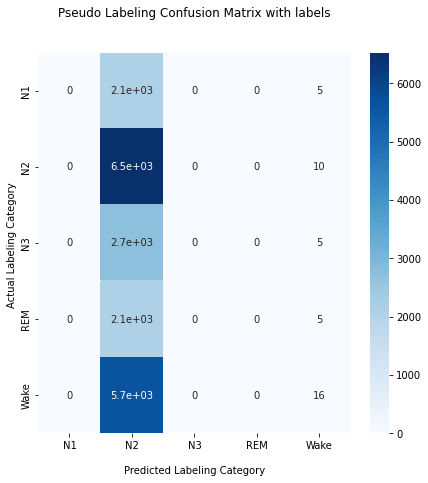

[1 1 1 ... 1 1 1]
[4 4 4 ... 4 4 4]


In [ ]:
y_pred = np.argmax(model.predict(dataset), axis=1)
y_labels = np.argmax(labels, axis=1)

Labels = ['N1','N2', 'N3', 'REM', 'Wake']

printConfusionMatrix(y_labels, y_pred, Labels)

#Labels = ['Sleep', 'Wake']
#y_pred = list(map(convertMultiLabelToSingleLabel, y_pred))
#test_labels = list(map(convertMultiLabelToSingleLabel, test_labels))

#printConfusionMatrix(y_labels, y_pred, Labels)

print(y_pred)
print(y_labels)